In [2]:
import os
import fastmri
from fastmri.data import transforms
import numpy as np
import torch
import pytorch_lightning as pl
import PIL
import pandas as pd
import h5py
from matplotlib import pyplot as plt

%matplotlib inline

/scratch/lgdejong/envs/thesis/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /lib64/libz.so.1: version `ZLIB_1.2.9' not found (required by /scratch/lgdejong/envs/thesis/lib/python3.9/site-packages/torchvision/../../../libpng16.so.16)
  warn(f"Failed to load image Python extension: {e}")


In [2]:
fastmri.__version__

'0.1.2a20210917b'

In [4]:
brain_mri_datapath = "/data/projects/recon/data/public/fastmri/brain/data/FLAIR/multicoil_train/"
mri_files = os.listdir(brain_mri_datapath)

annotation_path = "/home/lgdejong/scratch/projects/RecSeg/annotations/"
annotation_file = "brain.csv" 
annotation_file_list = "brain_file_list.csv"

annatations_df = pd.read_csv(os.path.join(annotation_path, annotation_file), index_col=None)
file_list_df = pd.read_csv(os.path.join(annotation_path, annotation_file_list), header=None)
file_names = file_list_df[0].to_list()
file_names = [i+".h5" for i in file_names]

non_lesion_files = annatations_df.loc[annatations_df['label'] != 'Nonspecific white matter lesion']
non_lesion_files = non_lesion_files['file'].unique()

annotated_file_names = set(mri_files).intersection(set(file_names))
annotated_file_names.difference_update(set(non_lesion_files))
annotated_file_names = list(annotated_file_names)
annotated_file_names.sort()
print(f"Sample count: {len(annotated_file_names)}")

Sample count: 342


In [87]:
def get_label(data_frame, file_name, slice=None):
    results = {}

    if file_name[-3:] == '.h5':
        file_name = file_name[:-3]

    file_label = data_frame.loc[data_frame['file'] == file_name]

    if slice is None:
        slice = list(file_label['slice'].unique())
    else:
        slice = [slice]

    for i in slice:
        label = file_label.loc[file_label['slice'] == i].values.tolist()
        results[i] = label

    return results

def kspace2image(mri_kspace, slice=None):
    results = []

    if slice:
        slice = [slice]
    else:
        slice = [i for i in range(mri_kspace.shape[0])]

    for i in slice:
        kspace_slice = mri_kspace[i]
        kspace_slice = transforms.to_tensor(kspace_slice)
        slice_image = fastmri.ifft2c(kspace_slice)
        slice_image = fastmri.complex_abs(slice_image)
        if len(kspace_slice.shape) == 4:
            slice_image = fastmri.rss(slice_image, dim=0)
        slice_image = np.abs(slice_image.numpy())
        results.append(slice_image)

    return np.stack(results, axis=0)

label = get_label(annatations_df, annotated_file_names[0])
print(label.keys(), label[0])

dict_keys([0, 1, 2, 3, 4, 7, 9]) [['file_brain_AXFLAIR_200_6002429', 0, 'No', 187.0, 221.0, 14.0, 22.0, 'Nonspecific white matter lesion'], ['file_brain_AXFLAIR_200_6002429', 0, 'No', 109.0, 203.0, 30.0, 62.0, 'Nonspecific white matter lesion'], ['file_brain_AXFLAIR_200_6002429', 0, 'No', 182.0, 101.0, 9.0, 15.0, 'Nonspecific white matter lesion'], ['file_brain_AXFLAIR_200_6002429', 0, 'No', 134.0, 96.0, 8.0, 14.0, 'Nonspecific white matter lesion']]


In [98]:
def center_crop(data, shape):
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to]

def plot_bounding_box(image, labels):
    plotted_image = PIL.ImageDraw.Draw(image)
    for label in labels:
        _, _, _, x0, y0, w, h, label_txt = label
        x1 = x0 + w
        y1 = y0 + h
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline="white")
        plotted_image.text((x0, max(0, y0 - 10)), label_txt, fill= "white")
    return np.array(image)

def meta_bounding_box_plot(image_tensor, label_dict):
    image_tensor = image_tensor[:, ::-1, :]
    slices, h, w = image_tensor.shape
    crop = min(h, w)
    image_tensor = center_crop(image_tensor, shape=(crop, crop))
    for i in range(slices):
        image = image_tensor[i, :, :]
        image = (np.maximum(image,0) / image.max()) * 255
        image = PIL.Image.fromarray(np.uint8(image))
        if i in label_dict.keys():
            image =  plot_bounding_box(image, label_dict[i])
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.show()

In [99]:
def read_kspace(root, filename):
    path = os.path.join(root, filename)
    hf = h5py.File(path)

    try:
        kspace = hf["kspace"]
    except KeyError:
        print("H5 file does not contain the kspace key.")
    return kspace

file_brain_AXFLAIR_200_6002429.h5


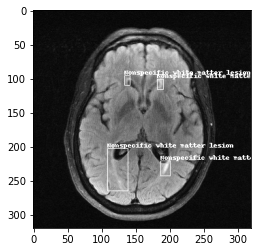

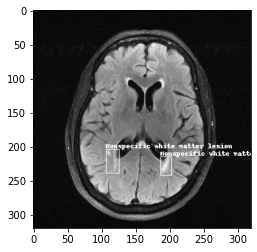

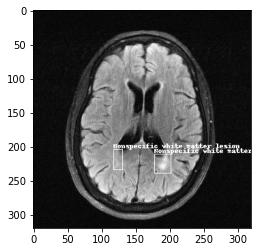

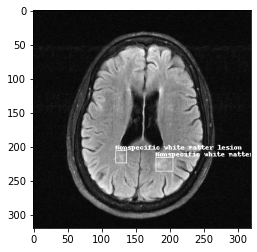

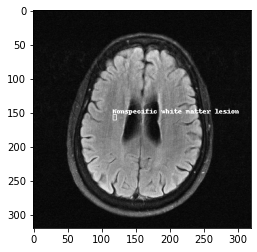

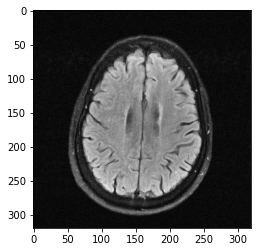

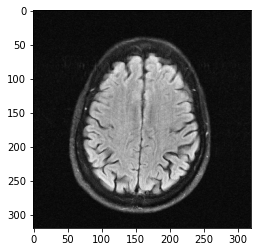

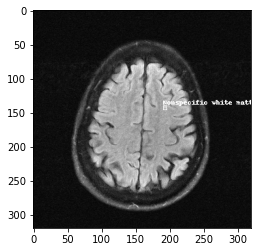

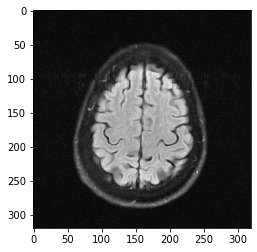

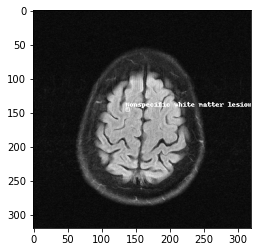

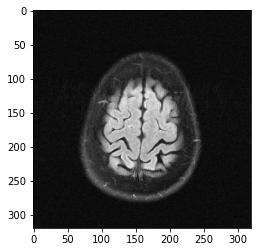

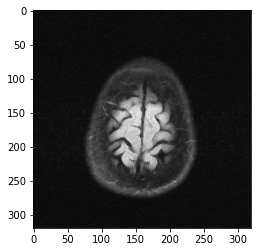

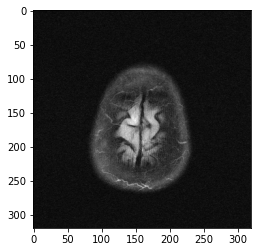

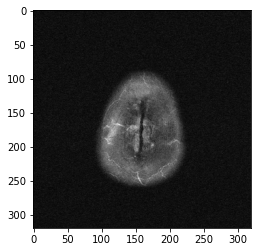

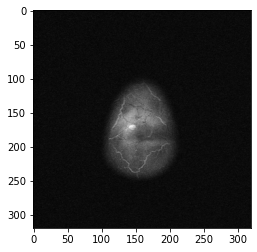

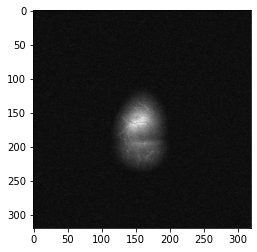

In [101]:
print(annotated_file_names[0])
kspace = read_kspace(brain_mri_datapath, annotated_file_names[0])
label = get_label(annatations_df, annotated_file_names[0])
images = kspace2image(kspace)
meta_bounding_box_plot(images, label)

Find out if the segmentation masks match up with SKM-TEA data.

In [12]:
raw_data_dir = "/data/projects/recon/data/public/qdess/v1-release/files_recon_calib-24/"
seg_data_dir = "/data/projects/recon/data/public/qdess/v1-release/segmentation_masks/raw-data-track/"

raw_files = os.listdir(raw_data_dir)
seg_files = os.listdir(seg_data_dir)

raw_files.sort()
seg_files.sort()

In [15]:
print(raw_files[:10])
print(seg_files[:10])

['MTR_001.h5', 'MTR_005.h5', 'MTR_006.h5', 'MTR_008.h5', 'MTR_010.h5', 'MTR_013.h5', 'MTR_015.h5', 'MTR_016.h5', 'MTR_018.h5', 'MTR_019.h5']
['MTR_001.nii.gz', 'MTR_005.nii.gz', 'MTR_006.nii.gz', 'MTR_008.nii.gz', 'MTR_010.nii.gz', 'MTR_013.nii.gz', 'MTR_015.nii.gz', 'MTR_016.nii.gz', 'MTR_018.nii.gz', 'MTR_019.nii.gz']


In [4]:
anno_dir = "D:/RecSeg/data/annotations"
files = os.listdir(anno_dir)
print(files)

['test.json', 'train.json', 'val.json']


In [5]:
import json

In [15]:
for j in files:
    with open(os.path.join(anno_dir, j)) as f:
        config = json.load(f)
    print([i["file_name"] for i in config["images"]])

['MTR_005', 'MTR_006', 'MTR_030', 'MTR_034', 'MTR_048', 'MTR_052', 'MTR_065', 'MTR_066', 'MTR_079', 'MTR_080', 'MTR_096', 'MTR_099', 'MTR_120', 'MTR_126', 'MTR_144', 'MTR_156', 'MTR_158', 'MTR_173', 'MTR_176', 'MTR_178', 'MTR_188', 'MTR_196', 'MTR_198', 'MTR_199', 'MTR_218', 'MTR_219', 'MTR_221', 'MTR_223', 'MTR_224', 'MTR_227', 'MTR_235', 'MTR_237', 'MTR_240', 'MTR_241', 'MTR_244', 'MTR_248']
['MTR_001', 'MTR_008', 'MTR_010', 'MTR_015', 'MTR_016', 'MTR_018', 'MTR_019', 'MTR_020', 'MTR_028', 'MTR_033', 'MTR_040', 'MTR_043', 'MTR_046', 'MTR_049', 'MTR_051', 'MTR_053', 'MTR_056', 'MTR_057', 'MTR_061', 'MTR_077', 'MTR_084', 'MTR_087', 'MTR_093', 'MTR_094', 'MTR_095', 'MTR_097', 'MTR_098', 'MTR_100', 'MTR_101', 'MTR_103', 'MTR_104', 'MTR_105', 'MTR_107', 'MTR_109', 'MTR_113', 'MTR_116', 'MTR_118', 'MTR_122', 'MTR_124', 'MTR_129', 'MTR_135', 'MTR_140', 'MTR_142', 'MTR_145', 'MTR_146', 'MTR_148', 'MTR_150', 'MTR_159', 'MTR_161', 'MTR_163', 'MTR_164', 'MTR_172', 'MTR_174', 'MTR_175', 'MTR_177

In [25]:
loss_coef = [1., 1., 0.01]
print(loss_coef/np.sum(loss_coef))

[0.49751244 0.49751244 0.00497512]


In [4]:
mri_flair = h5py.File("/data/projects/tecfidera/data/h5_new/nonorm/DMF007_T2_AXFLAIR.h5")
for i in mri_flair.keys():
    print(mri_flair[i])

<HDF5 dataset "kspace": shape (224, 32, 223, 163), type "<c8">
<HDF5 dataset "mask": shape (223, 163), type "<f4">
<HDF5 dataset "reconstruction_sense": shape (224, 223, 163), type "<f4">
<HDF5 dataset "sensitivity_map": shape (224, 32, 223, 163), type "<c8">


In [3]:
model_state_dict = torch.load("/data/projects/recon/other/dkarkalousos/projects/latest_paper/trained_models/best/gaussian2d_4x_6x_8x_10x/3T_T1_3D_Brains/CIRIM_8C8TS_64F_NODC_l1/best_model.pt")
print(model_state_dict.keys())
print(model_state_dict["args"])

FileNotFoundError: [Errno 2] No such file or directory: '/data/projects/recon/other/dkarkalousos/projects/latest_paper/trained_models/best/gaussian2d_4x_6x_8x_10x/3T_T1_3D_Brains/CIRIM_8C8TS_64F_NODC_l1/best_model.pt'

In [9]:
fast_mri_test = h5py.File("/data/projects/recon/data/public/fastmri/brain/data/FLAIR/multicoil_train/file_brain_AXFLAIR_200_6002429.h5")
for i in fast_mri_test.keys():
    print(fast_mri_test[i])

fast_mri_test = h5py.File("/data/projects/recon/data/public/fastmri/brain/sensitivities_maps/FLAIR/multicoil_train/file_brain_AXFLAIR_200_6002429.h5")
for i in fast_mri_test.keys():
    print(fast_mri_test[i])

<HDF5 dataset "ismrmrd_header": shape (), type "|O">
<HDF5 dataset "kspace": shape (16, 20, 640, 320), type "<c8">
<HDF5 dataset "reconstruction_rss": shape (16, 320, 320), type "<f4">
<HDF5 dataset "reconstruction": shape (5, 200, 163), type "<c8">
{'l1': array([0.37617958, 0.2663966 , 0.3378051 , 0.28049725, 0.14592114],
      dtype=float32), 'loss': array([0.37617958, 0.2663966 , 0.3378051 , 0.28049725, 0.14592114],
      dtype=float32), 'psnr': array([16.07563 , 19.405811, 17.325562, 18.414389, 21.6677  ],
      dtype=float32), 'ssim': array([0.05155067, 0.09292714, 0.10918323, 0.13578494, 0.48065737],
      dtype=float32)}


In [6]:
import mridc

In [6]:
from losses import MC_CrossEntropy

mc_crossentropy = MC_CrossEntropy(num_samples=10)
example_pred = torch.randn(3, 4, 320, 240, requires_grad=True)
example_log_var = torch.randn(3, 4, 320, 240, requires_grad=True)
example_target = torch.randint(0, 4, (3, 320, 240))

loss = mc_crossentropy(example_pred, example_target, example_log_var)
loss.backward()
print(loss)

tensor(2.1490, grad_fn=<MeanBackward0>)


In [30]:
import wandb
api = wandb.Api()
artifact = api.artifact('lysander/techfidera-recseg/model-wqzbqf9r:best', type='model')
test = artifact.get_path("model.ckpt")
print(test)
artifact_dir = test.download(root="/home/lgdejong/tmp/")

In [32]:
print(artifact_dir)
print(torch.load(artifact_dir).keys())

/home/lgdejong/tmp/model.ckpt
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


In [ ]:
def retrieve_checkpoint(model_id, project="techfidera-recseg", download_dir=None):
    api = wandb.Api()
    artifact_path = os.path.join("lysander", project, f"model-{model_id}:best")
    artifact = api.artifact(artifact_path, type="model")
    model_dir = artifact.get_path("model.ckpt").download(root=download_dir)
    return torch.load(model_dir)

In [16]:
def get_metrics(input_dir):
    results = {}
    files = sorted(os.listdir(input_dir))
    for f in files:
        input_path = os.path.join(input_dir, f)
        hf = h5py.File(input_path)
        hf_attr = dict(hf.attrs)

        for key, value in hf_attr.items():
            if key not in results:
                results[key] = list(value)
            else:
                results[key].extend(list(value))

    for key, value in results.items():
        print(f"{key}: \t {np.nanmean(np.ma.masked_invalid(np.array(value)))}")
    print("---------")

In [17]:
test1 = get_metrics("/scratch/lgdejong/results/reconstruction/cirim_1c_64f_poisson2d")
test2 = get_metrics("/scratch/lgdejong/results/reconstruction/cirim_8c_64f_poisson2d")
test1 = get_metrics("/scratch/lgdejong/results/segmentation/unet_3.7/")
test2 = get_metrics("/scratch/lgdejong/results/segmentation/unet_7.8/")

l1: 	 0.00315200281329453
loss: 	 0.00315200281329453
psnr: 	 41.069664001464844
ssim: 	 0.9806762337684631
---------
l1: 	 0.0020533569622784853
loss: 	 0.0020533569622784853
psnr: 	 43.37999725341797
ssim: 	 0.9898859262466431
---------
average_surface_distance: 	 1.4197522599974028
cross_entropy: 	 0.021062707528471947
dice_loss: 	 0.2226639837026596
dice_score: 	 0.777336061000824
f1_background: 	 0.9887387156486511
f1_graymatter: 	 0.6026423573493958
f1_lesion: 	 0.30223557353019714
f1_macro: 	 0.4810575246810913
f1_micro: 	 0.6086382865905762
f1_weighted: 	 0.608359158039093
f1_whitematter: 	 0.5382946133613586
hausdorff_distance: 	 10.95456185471221
loss: 	 0.2437267154455185
precision_background: 	 0.9912222623825073
precision_graymatter: 	 0.5887254476547241
precision_lesion: 	 0.2857215702533722
precision_macro: 	 0.4721953272819519
precision_micro: 	 0.5984176397323608
precision_weighted: 	 0.5994871854782104
precision_whitematter: 	 0.5421388149261475
recall_background: 	 0

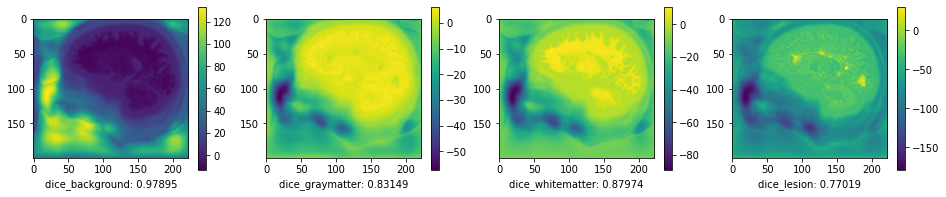

In [5]:
seg_dir = "/scratch/lgdejong/results/segmentation/unet_3.7/"
seg_files = os.listdir(seg_dir)
idx = 1
slice_idx = 95

input_path = os.path.join(seg_dir, seg_files[idx])
hf = h5py.File(input_path)
hf_attr = dict(hf.attrs)
segmentation = hf["segmentation"][slice_idx, ...]
label = ["dice_background", "dice_graymatter", "dice_whitematter", "dice_lesion"]
fig = plt.figure(figsize=(segmentation.shape[0]*segmentation.shape[0], segmentation.shape[0]-1))
for class_num, label_txt in enumerate(label):
    plt.subplot(1, segmentation.shape[0], class_num+1)
    ax = plt.imshow(segmentation[class_num])
    plt.colorbar(ax)
    plt.xlabel(f"{label_txt}: {hf_attr[label_txt][slice_idx]:.5f}")
plt.show()

<KeysViewHDF5 ['uncertainty']>
(221, 200, 163)


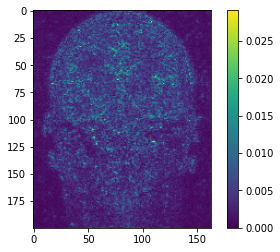

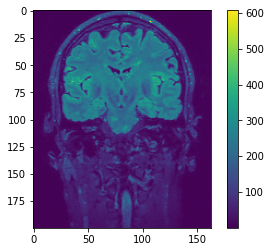

In [11]:
hf = h5py.File("/scratch/lgdejong/results/uncertainty/cirim_8c_64f_poisson2d/intermediate_variance/DMF007_T2_AXFLAIR_coronal.h5")
recon = h5py.File("/scratch/lgdejong/results/reconstruction/cirim_1c_64f_poisson2d/DMF007_T2_AXFLAIR_coronal.h5")
print(hf.keys())
print(hf["uncertainty"].shape)
ax = plt.imshow(hf["uncertainty"][slice_idx])
plt.colorbar(ax)
plt.show()
ax = plt.imshow(np.abs(recon["reconstruction"][slice_idx]))
plt.colorbar(ax)
plt.show()

<KeysViewHDF5 ['mc_sample_variance']>
(100, 200, 163)


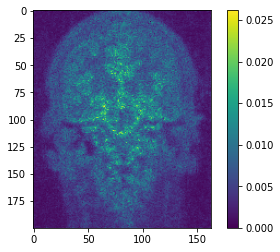

In [7]:
hf = h5py.File("/scratch/lgdejong/results/uncertainty/cirim_1c_64f_poisson2d/mc_variance/DMF007_T2_AXFLAIR_coronal.h5")
print(hf.keys())
print(hf["mc_sample_variance"].shape)
ax = plt.imshow(hf["mc_sample_variance"][slice_idx])
plt.colorbar(ax)
plt.show()

In [ ]:
def predict_recon(args, trainer, model, loader, out_dir):
    reconstructions = collections.defaultdict(lambda: collections.defaultdict(list))
    metric_dict = collections.defaultdict(lambda: collections.defaultdict(list))
    predictions = trainer.predict(model, dataloaders=loader, return_predictions=True,)

    for loss_dict, (fname, slice_int, pred) in predictions:
        fname = fname[0]
        reconstructions[fname]["reconstruction"].append(
            (slice_int, pred[-1].squeeze().numpy())
        )
        for metric, value in loss_dict.items():
            metric_dict[fname][metric].append(value.detach().mean().numpy())

    for fname in reconstructions:
        reconstructions[fname]["reconstruction"] = np.stack(
            [out for _, out in sorted(reconstructions[fname]["reconstruction"])]
        )

    save_h5(out_dir=out_dir, data_dict=reconstructions, metric_dict=metric_dict)
    get_metrics(input_dir=out_dir)


@torch.no_grad()
def predict_recon_v2(args, trainer, model, loader, out_dir):
    reconstructions = collections.defaultdict(lambda: collections.defaultdict(list))
    metric_dict = collections.defaultdict(lambda: collections.defaultdict(list))
    predictions = []
    with torch.cuda.device(args.gpus[0]):
        model.eval()
        model.cuda()

        for idx, batch in enumerate(tqdm(loader)):
            # print(torch.max(batch[0][0]))
            for k, item in enumerate(batch):
                if isinstance(item, torch.Tensor):
                    batch[k] = item.cuda()
                elif isinstance(item, (list, tuple)):
                    for j, c in enumerate(item):
                        if isinstance(c, torch.Tensor):
                            batch[k][j] = c.cuda()

            output = model.predict_step(batch, idx)
            predictions.append(output)

    for loss_dict, (fname, slice_int, pred) in predictions:
        fname = fname[0]
        # pred = (
        #     (torch.abs(pred[-1]) / torch.abs(pred[-1]).amax()).squeeze().cpu().numpy()
        # )
        pred = pred[-1].squeeze().cpu().numpy()
        reconstructions[fname]["reconstruction"].append((slice_int, pred))
        for metric, value in loss_dict.items():
            metric_dict[fname][metric].append(value.detach().mean().cpu().numpy())

    for fname in reconstructions:
        reconstructions[fname]["reconstruction"] = np.stack(
            [out for _, out in sorted(reconstructions[fname]["reconstruction"])]
        )

    save_h5(out_dir=out_dir, data_dict=reconstructions, metric_dict=metric_dict)
    get_metrics(input_dir=out_dir)


def predict_seg(args, trainer, model, loader, out_dir):
    segmentations = collections.defaultdict(lambda: collections.defaultdict(list))
    metric_dict = collections.defaultdict(lambda: collections.defaultdict(list))
    predictions = trainer.predict(model, dataloaders=loader, return_predictions=True,)

    for loss_dict, (fname, slice_int), pred in predictions:
        fname = fname[0]
        segmentations[fname]["segmentation"].append((slice_int, pred.squeeze().numpy()))
        for metric, value in loss_dict.items():
            metric_dict[fname][metric].append(value.detach().mean().numpy())

    for fname in segmentations:
        segmentations[fname]["segmentation"] = np.stack(
            [out for _, out in sorted(segmentations[fname]["segmentation"])],
        )

    save_h5(out_dir=out_dir, data_dict=segmentations, metric_dict=metric_dict)
    get_metrics(input_dir=out_dir)


def predict_uncertainty(args, trainer, model, loader, out_dir):
    uncertainty = collections.defaultdict(lambda: collections.defaultdict(list))
    metric_dict = collections.defaultdict(lambda: collections.defaultdict(list))
    predictions = trainer.predict(model, dataloaders=loader, return_predictions=True,)
    for loss_dict, (fname, slice_int, pred) in predictions:
        fname = fname[0]
        pred_stack = torch.stack(pred, dim=0)
        pred_stack = torch.abs(pred_stack) / torch.abs(pred_stack).amax((-1, -2), True)
        # un_stack = torch.sqrt(
        #     torch.square(pred_stack - pred_stack[-1]).sum(0) / pred_stack.shape[0]
        # )
        uncertainty[fname]["uncertainty"].append(
            (slice_int, pred_stack.squeeze().numpy())
        )
        for metric, value in loss_dict.items():
            metric_dict[fname][metric].append(value.numpy())

    for fname in uncertainty:
        uncertainty[fname]["uncertainty"] = np.stack(
            [out for _, out in sorted(uncertainty[fname]["uncertainty"])]
        )

    save_h5(
        out_dir=out_dir, data_dict=uncertainty, metric_dict=metric_dict,
    )


def predict_mc(args, trainer, model, loader, out_dir, mc_samples=1):
    uncertainty = collections.defaultdict(lambda: collections.defaultdict(list))
    tmp_dict = collections.defaultdict(lambda: collections.defaultdict(list))
    metric_dict = collections.defaultdict(lambda: collections.defaultdict(list))
    with torch.cuda.device(args.gpus[0]):
        with torch.no_grad():
            model.eval()
            enable_dropout(model)
            model.cuda()

            tmp = []
            prev_fname = ""
            for idx, batch in enumerate(tqdm(loader)):
                for k, item in enumerate(batch):
                    if isinstance(item, torch.Tensor):
                        batch[k] = item.cuda()
                    elif isinstance(item, (list, tuple)):
                        for j, c in enumerate(item):
                            if isinstance(c, torch.Tensor):
                                batch[k][j] = c.cuda()

                prediction = model.predict_step(batch, idx)
                loss_dict, (fname, slice_int, pred) = prediction
                fname = fname[0]
                # print(idx, slice_int, fname)
                if torch.is_complex(pred[-1]):
                    pred = [torch.abs(i) for i in pred]
                tmp.append(
                    (pred[-1] / pred[-1].amax((-1, -2), True)).squeeze().cpu().numpy()
                )
                for metric, value in loss_dict.items():
                    tmp_dict[fname][metric].append(value.cpu().numpy())

                if (idx + 1) % mc_samples == 0 and idx > 0:
                    uncertainty[fname]["mc_sample_variance"].append(
                        (slice_int, np.stack(tmp, axis=0))
                    )
                    for fname, metric_list_dict in tmp_dict.items():
                        for metric, value in metric_list_dict.items():
                            metric_dict[fname][metric].append(np.mean(value))
                            metric_dict[fname][f"{metric}_std"].append(np.std(value))
                    tmp = []
                    tmp_dict = collections.defaultdict(
                        lambda: collections.defaultdict(list)
                    )

                if prev_fname != fname:
                    for fname in uncertainty:
                        uncertainty[fname]["mc_sample_variance"] = np.stack(
                            [
                                out
                                for _, out in sorted(
                                    uncertainty[fname]["mc_sample_variance"]
                                )
                            ]
                        )

                    save_h5(
                        out_dir=out_dir, data_dict=uncertainty, metric_dict=metric_dict,
                    )
                    uncertainty = collections.defaultdict(
                        lambda: collections.defaultdict(list)
                    )
                    metric_dict = collections.defaultdict(
                        lambda: collections.defaultdict(list)
                    )
                prev_fname = fname

    # for fname in uncertainty:
    #     uncertainty[fname]["mc_sample_variance"] = np.stack(
    #         [out for _, out in sorted(uncertainty[fname]["mc_sample_variance"])]
    #     )

    # save_h5(
    #     out_dir=out_dir, data_dict=uncertainty, metric_dict=metric_dict,
    # )


def predict_seg_mc(args, trainer, model, loader, out_dir, mc_samples=1):
    uncertainty = collections.defaultdict(lambda: collections.defaultdict(list))
    tmp_dict = collections.defaultdict(lambda: collections.defaultdict(list))
    metric_dict = collections.defaultdict(lambda: collections.defaultdict(list))
    with torch.cuda.device(args.gpus[0]):
        with torch.no_grad():
            model.eval()
            enable_dropout(model)
            model.cuda()

            tmp = []
            for idx, batch in enumerate(tqdm(loader)):
                for k, item in enumerate(batch):
                    if isinstance(item, torch.Tensor):
                        batch[k] = item.cuda()
                    elif isinstance(item, (list, tuple)):
                        for j, c in enumerate(item):
                            if isinstance(c, torch.Tensor):
                                batch[k][j] = c.cuda()

                prediction = model.predict_step(batch, idx)
                loss_dict, (fname, slice_int), pred = prediction
                fname = fname[0]
                # print(idx, slice_int, fname)
                tmp.append(pred.squeeze().cpu().numpy())
                for metric, value in loss_dict.items():
                    tmp_dict[fname][metric].append(value.cpu().numpy())

                if (idx + 1) % mc_samples == 0 and idx > 0:
                    uncertainty[fname]["mc_sample_variance"].append(
                        (slice_int, np.stack(tmp, axis=0))
                    )
                    for fname, metric_list_dict in tmp_dict.items():
                        for metric, value in metric_list_dict.items():
                            metric_dict[fname][metric].append(np.mean(value))
                            metric_dict[fname][f"{metric}_std"].append(np.std(value))
                    tmp = []
                    tmp_dict = collections.defaultdict(
                        lambda: collections.defaultdict(list)
                    )

    for fname in uncertainty:
        uncertainty[fname]["mc_sample_variance"] = np.stack(
            [out for _, out in sorted(uncertainty[fname]["mc_sample_variance"])]
        )

    save_h5(
        out_dir=out_dir, data_dict=uncertainty, metric_dict=metric_dict,
    )


def save_h5(out_dir, data_dict, metric_dict):
    print(out_dir)
    for fname, recons in data_dict.items():
        with h5py.File(os.path.join(out_dir, fname), "w") as hf:
            for data_key, data in recons.items():
                hf.create_dataset(data_key, data=data)
            for metric, metric_list in metric_dict[fname].items():
                hf.attrs[metric] = np.array(metric_list)


def get_metrics(input_dir):
    results = {}
    files = sorted(os.listdir(input_dir))
    for f in files:
        input_path = os.path.join(input_dir, f)
        hf = h5py.File(input_path)
        hf_attr = dict(hf.attrs)

        for key, value in hf_attr.items():
            if key not in results:
                results[key] = list(value)
            else:
                results[key].extend(list(value))

    for key, value in results.items():
        print(f"{key}: \t {np.nanmean(np.ma.masked_invalid(np.array(value)))}")
    print("---------")

    return results


def enable_dropout(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith("Dropout"):
            each_module.train()